# Seattle Airbnb Data Analysis

This repository contains a comprehensive analysis of the [Seattle Airbnb
dataset](https://www.kaggle.com/datasets/airbnb/seattle/data), conducted using
the [CRoss Industry Standard Process for Data Mining -
CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)
methodology. 

The dataset includes detailed information about Airbnb listings, daily
availability, pricing, and user reviews in Seattle. The analysis aims to uncover
patterns and insights related to occupancy rates, pricing trends, and customer
satisfaction.

CRISP-DM methodology is consisted of the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation
6. Deployment

# 1. Business Understanding

*Objective: Understand the business objectives and requirements that motivate
data analysis.*

What is expected to be achieved with the analysis of the **Airbnb dataset in
Seattle**? Some possible objectives may be:

- **Q1. Identify temporal patterns in reserves and prices.**
- **Q2. Determine factors that influence property prices.**
- **Q3. Evaluate customer satisfaction based on reviews.**

# 2. Data Understanding

*Objective: Become familiar with the available data and evaluate its quality.*

## 2.1 Import libraries

In [1]:
import string
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /Users/mafda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mafda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mafda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Some functions

In [2]:
def read_dataset(csv_file):
    """
    Reads a CSV file into a DataFrame and prints its shape.
    
    Parameters:
    csv_file (str): The path to the CSV file.
    
    Returns:
    DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(csv_file)
    print("Number of rows and columns: ", df.shape)
    return df


def get_null_col(df):
    """
    Identifies columns with null values and returns a DataFrame with the counts 
    and percentages of nulls.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    
    Returns:
    DataFrame: A DataFrame with the counts and percentages of null values per 
    column. Returns None if no columns have null values.
    """
    # Get null values and the percentage
    pd.set_option("display.precision", 2)
    null_col = df.columns[df.isna().sum() > 0]
    col_null_val = df[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (df[null_col].isna().sum() / df.shape[0] * 100).sort_values(
        ascending=False
    )
    # Create a dataframe with results per column
    if len(col_null_val) > 0:
        nulls_df = pd.DataFrame(col_null_val, columns=["#"])
        nulls_df["%"] = per_null_val
        print("Number of columns with missing data:", nulls_df.shape[0])
        return nulls_df
    else:
        print("No missing data")


def drop_cols(df):
    """
    Cleans the DataFrame by dropping columns with more than 50% null values,
    columns with a single unique value, and duplicate columns.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Identify columns with more than 50% null values
    null_percentage = df.isnull().mean() * 100
    columns_to_drop = null_percentage[null_percentage > 50].index
    print("Columns with more than 50% null values:", len(columns_to_drop))

    if len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop, axis=1)
        print("Drop columns:", columns_to_drop)

    # Identify columns with a single value
    unique_value_columns = [
        col for col in df.columns if df[col].nunique() == 1
    ]
    print("Columns with a unique value:", len(unique_value_columns))

    if len(unique_value_columns) > 0:
        df = df.drop(columns=unique_value_columns, axis=1)
        print("Drop columns:", unique_value_columns)

    # Drop duplicate column
    duplicated_columns = set()
    for i in range(len(df.columns)):
        col1 = df.columns[i]
        for j in range(i + 1, len(df.columns)):
            col2 = df.columns[j]
            if df[col1].equals(df[col2]):
                duplicated_columns.add(col2)
    print("Duplicate column:", len(duplicated_columns))

    if len(duplicated_columns) > 0:
        df = df.drop(columns=duplicated_columns, axis=1)

    print("Data cleaned:", df.shape)

    return df


def drop_rows(df, rows):
    """
    Drops rows from the DataFrame where columns have less than a specified 
    number of null values.

    Parameters:
    df (DataFrame): The input DataFrame.
    rows (int): The threshold number of null values.

    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Show the number of null values ​​in each column
    null_counts = df.isnull().sum()
    drop_column = []

    # Check if any column has less than # rows with null values
    for column in df.columns:
        if null_counts[column] < rows and null_counts[column] > 0:
            # Delete rows with null values ​​in that column
            df.dropna(subset=column, axis=0, inplace=True)
            drop_column.append(column)

    print(f"Rows with less than {rows} null values:", len(drop_column))
    print(drop_column)
    print("Data cleaned:", df.shape)

    return df


def remove_symbol(df, symbol, cols):
    """
    Removes a specified symbol from columns and formats the columns as float.

    Parameters:
    df (DataFrame): The input DataFrame.
    symbol (str): The symbol to remove.
    cols (list): List of column names to format.

    Returns:
    None
    """
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(symbol, "")
            .str.replace(",", "")
            .astype("float32")
        )


def transform_datetime(df, columns):
    """
    Converts specified columns to datetime type.

    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to convert.

    Returns:
    None
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")


def transform_bool(df, columns):
    """
    Transforms specified boolean columns from 't'/'f' to True/False.

    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to transform.

    Returns:
    None
    """
    for col in columns:
        df[col] = df[col].map({"t": 1, "f": 0}).astype("bool")


def mean_missing_values(df, columns):
    """
    Fills missing values in specified numerical columns with the mean of the 
    column.

    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of numerical column names to fill missing values.

    Returns:
    None
    """
    for col in columns:
        df[col].fillna(df[col].mean(), inplace=True)


def mode_missing_values(df, columns):
    """
    Fills missing values in specified categorical columns with the mode of the 
    column.

    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of categorical column names to fill missing values.

    Returns:
    None
    """
    for col in columns:
        df[col].fillna(df[col].mode()[0], inplace=True)


def clean_text(text):
    """
    Cleans text by converting to lowercase, removing punctuation, and removing 
    stopwords.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The cleaned text.
    """
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    text = " ".join([word for word in words if word not in stop_words])
    return text


def get_sentiment_vader(text):
    """
    Analyzes sentiment of text using VADER and returns the compound sentiment 
    score.

    Parameters:
    text (str): The input text to analyze.

    Returns:
    float: The compound sentiment score.
    """
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores["compound"]


def feeling_comments(df, feeling, samples):
    """
    Prints random comments from a DataFrame based on specified sentiment 
    category.

    Parameters:
    df (DataFrame): The input DataFrame containing comments and sentiment 
    categories.
    feeling (str): The sentiment category to filter comments by.
    samples (int): The number of random comments to print.

    Returns:
    None
    """
    print(f"Random comments with {feeling} sentiment:")
    sample_comments = (
        df.loc[df["sentiment_category_vader"] == feeling, ["comments"]]
        .sample(samples)
        .values
    )
    for comment in sample_comments:
        print("* " + comment[0])


## 2.2 Load datasets

### Calendar Dataset

In [3]:
df_calendar = read_dataset('../data/calendar.csv')
df_calendar.head(2)

Number of rows and columns:  (1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [4]:
get_null_col(df_calendar)

Number of columns with missing data: 1


,#,%
price,459028,32.94


### Listings Dataset

In [5]:
df_listings = read_dataset('../data/listings.csv')
df_listings.head(2)

Number of rows and columns:  (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [6]:
get_null_col(df_listings)

Number of columns with missing data: 46


,#,%
license,3818,100.00
square_feet,3721,97.46
monthly_price,2301,60.27
security_deposit,1952,51.13
weekly_price,1809,47.38
notes,1606,42.06
neighborhood_overview,1032,27.03
cleaning_fee,1030,26.98
transit,934,24.46
host_about,859,22.50


### Reviews Dataset

In [7]:
df_reviews = read_dataset('../data/reviews.csv')
df_reviews.head(2)

Number of rows and columns:  (84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [8]:
get_null_col(df_reviews)

Number of columns with missing data: 1


,#,%
comments,18,0.02


## 3. Data Preparation

*Objective: Clean and transform data so that it is ready for analysis or modeling.*

### Calendar Dataset

- `df_calendar` has 1393570 lines and 4 columns. 
- The number of columns with missing data is 1 with 32.94% missing values.

#### Clean and transform data

- In the `price` column, we removed the $ symbol and converted it to float type.
- The `date` column was converted to datetime type.
- Due to the `price` column having approximately 33% missing values, after
  standardizing the values, the adopted strategy was to fill the missing values
  with the mean of this column.
- To address the question "*Identify temporal patterns in reserves and prices*":
  - We created two new columns, month and year.
  - Finally, we transformed the available column to bool type.

In [9]:
# Clear and convert 'price' column
remove_symbol(df_calendar, "$", ["price"])

# Dealing with numerical missing values columns 
mean_missing_values(df_calendar, ["price"])

# Convert date column to datetime type
transform_datetime(df_calendar, ["date"])

# Create new columns for month and year
df_calendar["month"] = df_calendar["date"].dt.month
df_calendar["year"] = df_calendar["date"].dt.year

# Convert the available column to 1 or 0
transform_bool(df_calendar, ["available"])

After cleaning and transforming the data, we check if we have columns with
unique values ​​or duplicate columns, and finally, we check again if we still
have missing data.

In [10]:
# Treatment of null values
calendar_cleaned = drop_cols(df_calendar)

Columns with more than 50% null values: 0
Columns with a unique value: 0
Duplicate column: 0
Data cleaned: (1393570, 6)


In [11]:
# Check for null values ​​after cleanup
get_null_col(calendar_cleaned)

No missing data


Once the data was cleaned and processed, and we have the dataset ready, we can
start the exploratory analysis.

#### Exploratory analysis

- **Q1. Identify temporal patterns in reserves and prices**

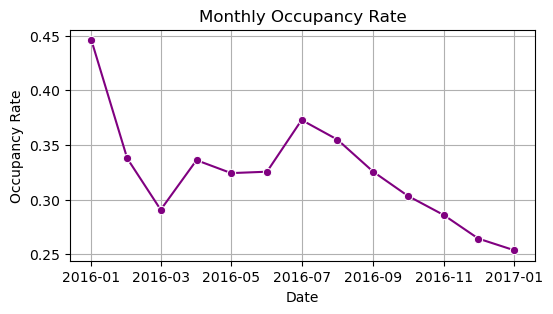

In [12]:
# Calculate monthly occupancy rate
occupancy_rate = (
    calendar_cleaned.groupby(["year", "month", "listing_id"])["available"]
    .mean()
    .reset_index()
)
occupancy_rate["occupancy_rate"] = 1 - occupancy_rate["available"]
occupancy_rate = occupancy_rate.drop("available", axis=1)
monthly_occupancy = (
    occupancy_rate.groupby(["year", "month"])["occupancy_rate"]
    .mean()
    .reset_index()
)

# Create a date column from the year and month
monthly_occupancy["date"] = pd.to_datetime(
    monthly_occupancy[["year", "month"]].assign(day=1)
)

# Graph monthly occupancy rate
plt.figure(figsize=(6, 3))
sns.lineplot(
    data=monthly_occupancy,
    x="date",
    y="occupancy_rate",
    marker="o",
    color="purple",
)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.title("Monthly Occupancy Rate")
plt.grid(True)
plt.show()

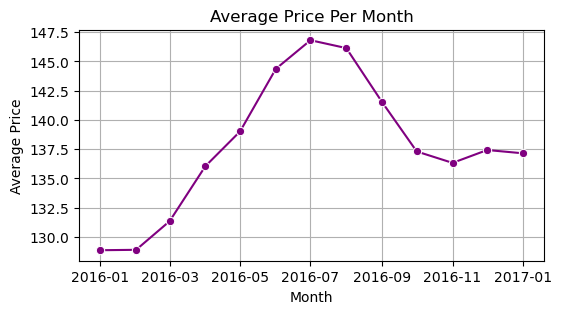

In [13]:
# Calculate monthly average price
avg_price_per_month = (
    calendar_cleaned.groupby(["year", "month"])["price"].mean().reset_index()
)

# Create a date column from the year and month
avg_price_per_month["date"] = pd.to_datetime(
    avg_price_per_month[["year", "month"]].assign(day=1)
)

# Graph price trend
plt.figure(figsize=(6, 3))
sns.lineplot(
    data=avg_price_per_month,
    x="date",
    y="price",
    marker="o",
    color="purple",
)
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title("Average Price Per Month")
plt.grid(True)
plt.show()

#### Analysis of Results

- **Occupancy Rate**: The occupancy rate in Seattle shows distinct temporal
  patterns. The highest occupancy rate was observed in January 2016, which then
  decreased until March 2016. However, there was another increase in July 2016,
  starting from March 2016, which then began to decline until January 2017. This
  indicates a seasonal trend with peaks in winter (January) and summer (July),
  followed by gradual decreases.

- **Prices**: The average monthly prices also exhibit a temporal pattern.
  January 2016 had the lowest average price, which then increased steadily until
  July 2016. After July, prices slightly decreased until November 2016 and
  remained stable through January 2017. This suggests that prices tend to rise
  during periods of higher occupancy and demand, peaking in the summer.

The analysis reveals a relationship between occupancy rates and prices. Both
show seasonal trends with peaks in July and January, although prices lag
slightly behind occupancy rates. This correlation suggests that higher occupancy
rates, likely driven by seasonal demand, are associated with higher prices. This
pattern can be used to inform pricing and availability strategies for Airbnb
hosts in Seattle.

### Listings Dataset


- `df_listings` has 3818 lines and 92 columns. 
- The number of columns with missing data is 46 between 0.03% and 100% missing values.

#### Clean data

- First, we verified and eliminated all columns with more than 50% missing
  values, as well as those with unique values and duplicated columns.
- Next, we checked for rows with fewer than 10 missing values and removed those
  rows.
- We also decided to eliminate all columns with "url" in their name, as they do
  not add value to our analysis.

In [14]:
# Treatment of null values
listings_cleaned = drop_cols(df_listings)

Columns with more than 50% null values: 4
Drop columns: Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')
Columns with a unique value: 10
Drop columns: ['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']
Duplicate column: 1
Data cleaned: (3818, 77)


In [15]:
# Treatment of null values
listings_cleaned = drop_rows(listings_cleaned, 10)

Rows with less than 10 null values: 14
['host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'zipcode', 'property_type', 'bedrooms', 'beds']
Data cleaned: (3795, 77)


In [16]:
# Identify columns that contain "url" in their name
url_columns = [col for col in listings_cleaned.columns if "url" in col.lower()]
print("Columns with 'url' in their name:")
print(url_columns)

# Remove columns that contain "url" in their name
listings_cleaned = listings_cleaned.drop(columns=url_columns, axis=1)
print(listings_cleaned.shape)

Columns with 'url' in their name:
['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
(3795, 69)


- After cleaning the null data, we reviewed the remaining columns.
- Next, we grouped the columns according to **host**, **review**, or
  **property** profile, selecting those that best fit and guide us to answer the
  question "*Determine factors that influence property prices*."

In [17]:
# Check remaining columns after removing null values
print(listings_cleaned.columns)

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review',

In [18]:
# Feature selection
host_features = [
    "host_since",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_listings_count",
    "host_verifications",
    "host_has_profile_pic",
    "host_identity_verified",
    "calculated_host_listings_count",
]

review_features = [
    "instant_bookable",
    "cancellation_policy",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "reviews_per_month",
    "number_of_reviews",
    "first_review",
    "last_review",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

property_features = [
    "neighbourhood",
    "latitude",
    "longitude",
    "is_location_exact",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "amenities",
    "price",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
]

features = host_features + review_features + property_features
listings_filtered = listings_cleaned.filter(features, axis=1)
listings_filtered.shape

(3795, 43)

#### Transform data

- We reduced the dataframe from 3818 x 92 to 3795 x 43.
- Removed symbols like $ and % from the selected columns and transformed them to
  float type.
  -  `price, cleaning_fee, extra_people`
  -  `host_response_rate, host_acceptance_rate`
- Converted selected columns to datetime type.
  - `host_since, first_review, last_review`
- Formatted categorical columns to numeric for better analysis.
  - `host_response_time, cancellation_policy`
- Transformed selected columns to boolean type.
  - `host_is_superhost, host_has_profile_pic, host_identity_verified, instant_bookable, require_guest_profile_picture, require_guest_phone_verification, require_guest_profile_picture, require_guest_phone_verification, is_location_exact`

In [19]:
# Remove symbols
remove_symbol(
    listings_filtered, "$", ["price", "cleaning_fee", "extra_people"]
)
remove_symbol(
    listings_filtered, "%", ["host_response_rate", "host_acceptance_rate"]
)

# Convert date column to datetime type
transform_datetime(
    listings_filtered, ["host_since", "first_review", "last_review"]
)

In [20]:
# Reformat other features
listings_filtered[
    "host_response_time"
] = listings_filtered.host_response_time.map(
    {
        "within an hour": 1,
        "within a few hours": 12,
        "within a day": 24,
        "a few days or more": 48,
    }
)
listings_filtered["cancellation_policy"] = listings_filtered[
    "cancellation_policy"
].map({"strict": 0, "moderate": 1, "flexible": 2})

In [21]:
# Transform the bool features
bool_features = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "is_location_exact",
]

transform_bool(listings_filtered, bool_features)

We check again for null values ​​in the columns.

In [22]:
# Check missing data
get_null_col(listings_filtered)

Number of columns with missing data: 16


,#,%
cleaning_fee,1018,26.82
host_acceptance_rate,764,20.13
review_scores_accuracy,647,17.05
review_scores_checkin,647,17.05
review_scores_value,645,17.00
review_scores_location,644,16.97
review_scores_cleanliness,642,16.92
review_scores_communication,640,16.86
review_scores_rating,636,16.76
reviews_per_month,616,16.23


Since the missing data ranges from 0.4% to 27%, the strategy we adopted was to
fill the missing data with the mean of the column for numerical columns and the
mode of the column for categorical columns.

In [23]:
# Dealing with numerical missing values columns
numerical_missing_values = [
    "beds",
    "bedrooms",
    "bathrooms",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_listings_count",
    "cleaning_fee",
    "review_scores_accuracy",
    "review_scores_checkin",
    "review_scores_value",
    "review_scores_location",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_rating",
    "reviews_per_month",
]
mean_missing_values(listings_filtered, numerical_missing_values)

In [24]:
# Dealing with categorical missing values columns
categorical_missing_values = [
    "property_type",
    "neighbourhood",
    "first_review",
    "last_review",
    "host_since",
]
mode_missing_values(listings_filtered, categorical_missing_values)

In [25]:
# Check missing data
get_null_col(listings_filtered)

No missing data


Once the data was cleaned and processed, and we have the dataset ready, we can
start the exploratory analysis.

#### Exploratory analysis

- **Q2. Determine factors that influence property prices.**

In [26]:
# Price describe
listings_filtered['price'].describe()

count    3795.00
mean      127.92
std        90.27
min        20.00
25%        75.00
50%       100.00
75%       150.00
max      1000.00
Name: price, dtype: float64

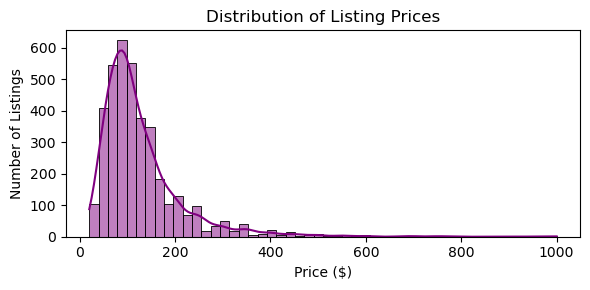

In [27]:
# Price Distribution
plt.figure(figsize=(6, 3))
sns.histplot(listings_filtered['price'], bins=50, kde=True, color="purple")
plt.title('Distribution of Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

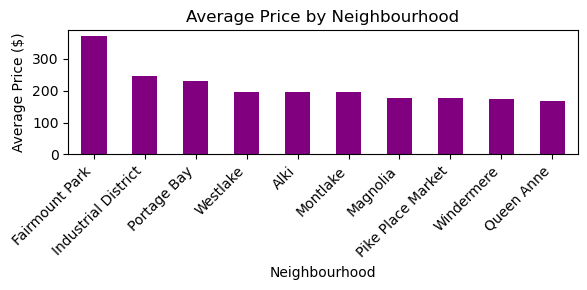

In [28]:
# Average Price by Neighbourhood
avg_price_by_neighbourhood = (
    listings_filtered.groupby("neighbourhood")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(6, 3))
avg_price_by_neighbourhood.plot(kind="bar", color="purple")
plt.title("Average Price by Neighbourhood")
plt.xlabel("Neighbourhood")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

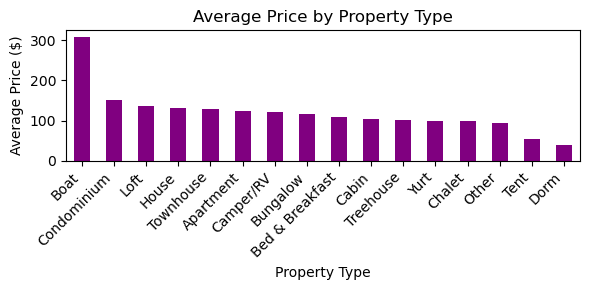

In [29]:
# Average Price by Property Type
avg_price_by_property = (
    listings_filtered.groupby("property_type")["price"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(6, 3))
avg_price_by_property.plot(kind="bar", color="purple")
plt.title("Average Price by Property Type")
plt.xlabel("Property Type")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

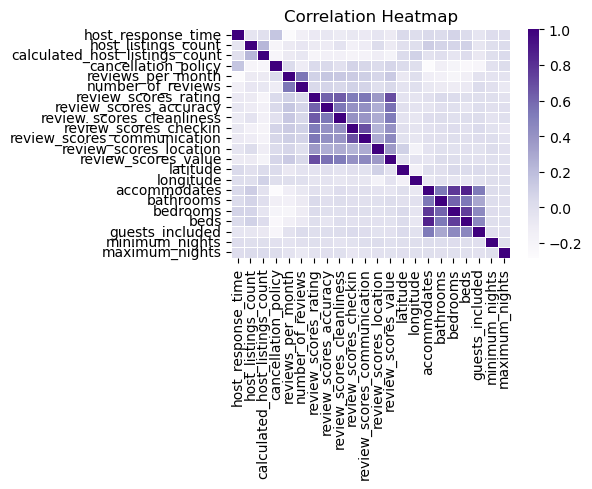

In [30]:
# Select relevant numeric columns
numeric_columns = listings_filtered.select_dtypes(include=["float64", "int64"])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=False, cmap="Purples", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

#### Analysis of Results

- **Price Distribution**: The histogram shows that most listings are priced
  around 100, with over 600 properties in this range. This suggests that $100
  is a common price for Airbnb listings in Seattle, possibly indicating a
  competitive and affordable market for most travelers.
- **Prices by Neighborhood**: The results of the bar plot indicate that the most
  expensive neighborhoods are Fairmount Park, standing out as one of the most
  expensive areas to stay. This analysis can be useful in identifying premium
  neighborhoods and helping homeowners adjust their prices based on location.
- **Correlations between Variables**: The correlation matrix shows that there is
  a high correlation between price and review-related variables (such as number
  of reviews and review score). Significant correlations are also observed with
  the number of bathrooms, beds, bedrooms, accommodation capacity and number of
  guests included. This suggests that these factors are key determinants of
  listing prices, with larger, better-reviewed properties tending to command
  higher prices.

The analyzes performed provide a clear view of the pricing dynamics in Airbnb
listings in Seattle. Understanding the distribution of prices, the factors that
affect them, and how they vary by property type and location can help homeowners
make informed decisions about pricing and marketing strategies.

### Reviews Dataset

- `df_reviews` has 84849 lines and 6 columns. 
- The number of columns with missing data is 1 with 0.02% missing values.

#### Clean and transform data

- Since the `comments` column has approximately 0.02% missing values, the adopted strategy was to delete the rows with missing values as it would not have a significant impact on subsequent analyses.
- We checked for columns with unique values or duplicated columns and removed such cases.
- The `date` column was converted to datetime type.
- To address the question "*Evaluate customer satisfaction based on reviews*"
  - We cleaned and standardized the text in the `comments` column. This involved converting text to lowercase, removing punctuation, and eliminating stopwords.

In [31]:
# Treatment of null values
reviews_cleaned = drop_rows(df_reviews, 20)

Rows with less than 20 null values: 1
['comments']
Data cleaned: (84831, 6)


In [32]:
# Treatment of null values
reviews_cleaned = drop_cols(reviews_cleaned)

Columns with more than 50% null values: 0
Columns with a unique value: 0
Duplicate column: 0
Data cleaned: (84831, 6)


In [33]:
# Convert date column to datetime type
transform_datetime(reviews_cleaned, ["date"])

In [34]:
# Clean and standardized text
reviews_cleaned['comments'] = reviews_cleaned['comments'].apply(clean_text)

Once the data was cleaned and processed, and we have the dataset ready, we can
start the exploratory analysis.

#### Exploratory Analysis

- **Q3. Evaluate customer satisfaction based on reviews**

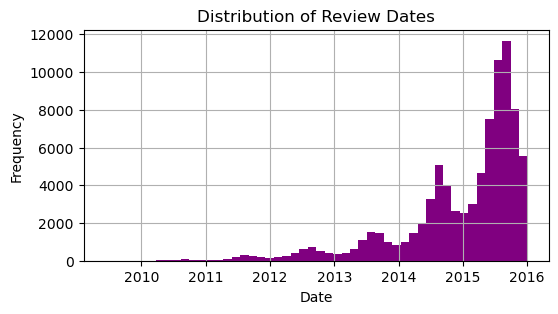

In [35]:
# Date distribution of reviews
plt.figure(figsize=(6, 3))
reviews_cleaned['date'].hist(bins=50, color="purple")
plt.title('Distribution of Review Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

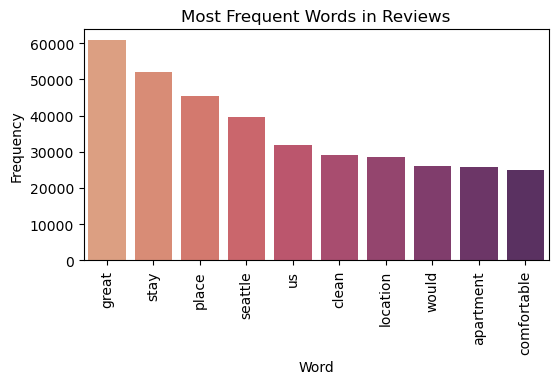

In [36]:
# Analysis of the most frequent words in the reviews
# Join all comments
all_comments = ' '.join(reviews_cleaned['comments'].tolist())

# Count the most frequent words
word_counts = Counter(all_comments.split())
common_words = word_counts.most_common(10)

# Display the most frequent words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(6, 3))
sns.barplot(x='Word', y='Frequency', data=common_words_df, palette="flare")
plt.title('Most Frequent Words in Reviews')
plt.xticks(rotation=90)
plt.show()

In [37]:
# Apply sentiment analysis
reviews_cleaned["sentiment_vader"] = reviews_cleaned["comments"].apply(
    get_sentiment_vader
)

# Categorize feelings as positive, negative or neutral
reviews_cleaned["sentiment_category_vader"] = reviews_cleaned[
    "sentiment_vader"
].apply(
    lambda score: "positive"
    if score > 0
    else ("negative" if score < 0 else "neutral")
)

In [38]:
# Count feelings using VADER
sentiment_counts_vader = reviews_cleaned[
    "sentiment_category_vader"
].value_counts()

# Calculate the proportion of each sentiment category
sentiment_proportions_vader = (
    sentiment_counts_vader / len(reviews_cleaned)
) * 100

reviews_cleaned.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment_vader,sentiment_category_vader
0,7202016,38917982,2015-07-19,28943674,Bianca,cute cozy place perfect location everything,0.77,positive
1,7202016,39087409,2015-07-20,32440555,Frank,kelly great room central location beautiful bu...,0.99,positive


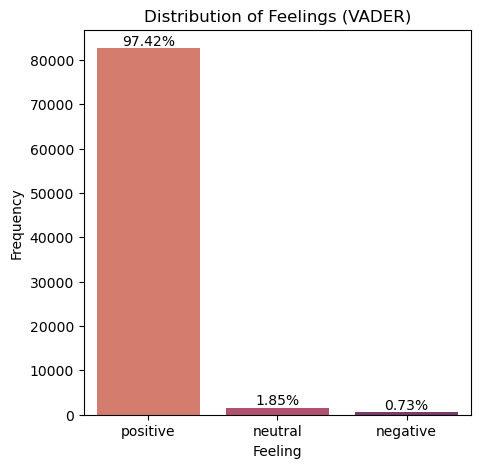

In [39]:
# Graph the distribution of feelings
plt.figure(figsize=(5, 5))
sns.barplot(
    x=sentiment_counts_vader.index,
    y=sentiment_counts_vader.values,
    palette="flare",
)

# Add proportion labels to each bar
for i, proportion in enumerate(sentiment_proportions_vader):
    plt.text(
        i,
        sentiment_counts_vader.values[i],
        f"{proportion:.2f}%",
        ha="center",
        va="bottom",
    )

plt.title("Distribution of Feelings (VADER)")
plt.xlabel("Feeling")
plt.ylabel("Frequency")
plt.show()

In [40]:
feeling_comments(reviews_cleaned, "positive", 2)

Random comments with positive sentiment:
* zen retreat perfect place stay us great place base busy sightseeing days neighborhood quiet houses decor relaxing long day great grab quick bite local market relax evening matt good host responsive questions
* cozy little place love extra study room party lighted porch looking onto ancient apple tree allison john attentive every need unit felt nicely clean wish kitchenette sink bathroom sink suffices keurig machine terrific thank allison john


In [41]:
feeling_comments(reviews_cleaned, "negative", 2)

Random comments with negative sentiment:
* wir haben uns sehr wohl gefühlt dieser kleinen gemütlichen cabin umgeben von einem lauschigen bambusgarten netter rückzugspunktich habe gerne die mit den basics ausgestattete küche genutzt gute lage wenn man mit öffentlichen verkehrsmitteln unterwegs ist drei busse halten um die ecke und fahren downtown und zur metrostation union street von wo aus man anschluß alle richtungen hat
* tayyab war bei unserer ankunft persönlich vor ort da wir später als geplant ankamen und unser leihauto nicht mehr zurückgeben konnten organisierte tayyab einen sicheren tiefgaragenplatz er gab uns gute tips für die zwei tage seattle die unterkunft war wie beschrieben lag zentral und bot eine tolle sicht auf seattle alles war bestens


In [42]:
feeling_comments(reviews_cleaned, "neutral", 2)

Random comments with neutral sentiment:
* host sent message soon landed let know options get unit airport access unit arrived
* 모든게 설명한대로 였습니다 아주 좋았습니다


#### Analysis of Results

- **Review Volume**: The year 2016 had the highest number of user reviews,
  indicating a significant level of engagement and feedback from customers
  during that period.
- **Commonly Used Words**: The most frequently used words in user reviews were
  "great," "clean," "location," and "comfortable." These keywords suggest that
  customers generally had positive experiences and appreciated the cleanliness,
  location, and comfort of the accommodations.

**Sentiment Analysis**:

- Positive Reviews: 97.42% of the comments were positive, reflecting a high
  level of customer satisfaction.
- Neutral Reviews: 1.85% of the comments were neutral.
- Negative Reviews: Only 0.73% of the comments were negative, indicating a very
  low level of dissatisfaction among users.
- *Language of Reviews: Some of the reviews classified as neutral or negative
  were written in languages other than English. This language variation could
  impact the accuracy of sentiment classification.*

**Suggestion**: It is recommended to clean the data to include only comments
written in English. This step would ensure more consistent and accurate
sentiment analysis, leading to better insights into customer satisfaction.

Overall, the analysis shows that customer satisfaction is overwhelmingly
positive, with a few areas for improvement in handling multilingual reviews.

# 4. Data Modeling

*Objective: Apply modeling techniques to identify patterns or predict values.*

**Linear Regression** is a simple model that attempts to capture the linear
relationship between features and price.
- Pros: Easy to interpret and quick to train.
- Cons: May not capture complex relationships between variables.

In [43]:
# Define the characteristics (X) and the objective (y)
X = listings_filtered[
    [
        "accommodates",
        "bathrooms",
        "bedrooms",
        "beds",
        "guests_included",
        "reviews_per_month",
        "number_of_reviews",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
        "cleaning_fee",
        "host_response_rate",
        "host_acceptance_rate",
        "host_is_superhost",
    ]
]
y = listings_filtered["price"]

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [44]:
# We train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
# Predict on validation set
y_pred = model.predict(X_valid)

# 5. Evaluation

*Objective: Evaluate the results of the model in terms of accuracy and usefulness for the business.*

In [46]:
# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 3239.9372327865867
Mean Absolute Error (MAE): 38.09052779964685
R² Score: 0.5576846223142518


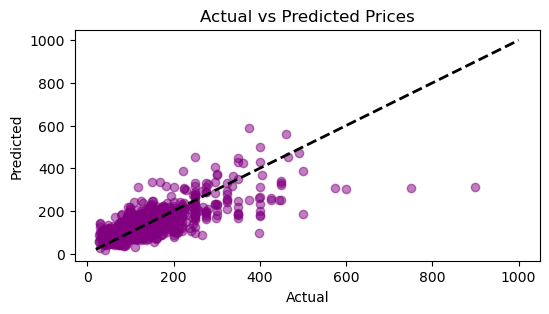

In [47]:
# View the results
plt.figure(figsize=(6,3))
plt.scatter(y_valid, y_pred, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.show()

#### Analysis of Results

- An MAE of 38.09 means that, on average, the model predictions are off from the
  actual value by approximately $38.09. This is a more interpretable value and
  less sensitive to outliers compared to the MSE. A reduction in the MAE
  indicates that the model is improving in terms of absolute accuracy.
- An R² of 0.558 indicates that approximately 55.8% of the variability in
  property prices can be explained by the model. This suggests moderate to good
  predictive ability.
- Although the model has a reasonable level of predictive ability, an R² of
  0.558 also suggests that there is 44.2% of the variability that is not being
  captured by the model, indicating that some important features could be
  missing or that the model is not complex enough to Capture all relationships
  present in the data.

# 6. Deployment

*Objective: Implement the solution so that it can be used by the business.*

- Automate the data pipeline: 
  - Use scripts and tools to automate data collection, cleaning and analysis.
- Deploy the model to production: 
  - Use cloud services such as AWS, GCP or Azure to deploy the model.
  - Create an API so that other systems can access the model.

## Conclusions

Steps to **improve** the `model`:

- Explore more price-relevant features.
- Test more complex models that can capture non-linear relationships.
- Apply regularization techniques to improve the robustness of the model.
- Perform an analysis and treatment of outliers.
- Use cross-validation for a more robust evaluation.